In [21]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import numpy as np
import deepthought, math, mne, os
import pandas as pd
import torch
import torch.nn as nn

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [23]:
# experiment
STIMULUS_IDS = [1, 2, 3, 4, 11, 12, 13, 14, 21, 22, 23, 24]
CATEGORIES = 12
CONDITIONS = ['cued', 'non-cued', 'free']


def get_stimuli_version(subject):
    if subject in ['P01','P04','P05','P06','P07']:
        return 1
    else:
        return 2

def load_stimuli_metadata(data_root=None, version=None, verbose=None):
    import warnings
    warnings.simplefilter("ignore")
    if version is None:
        version = 1

    if data_root is None:
        data_root = '/home/username/Desktop/datasets/openmiir'

    file_name = os.path.join(data_root, 'meta', 'Stimuli_Meta.v{}.xlsx'.format(version))
    dfs = pd.read_excel(file_name, sheet_name=None)["Sheet1"]


    if verbose:
        log.info('Loading stimulus metadata from {}'.format(xlsx_filepath))


    meta = dict()
    for i in range(CATEGORIES):
        stimulus_id = dfs.iloc[i]["id"]
        meta[stimulus_id] = {
            'id' : stimulus_id,
            'category': i,
            'label' : dfs.iloc[i]["song"],
            'audio_file' : dfs.iloc[i]["audio file"],
            'cue_file' : dfs.iloc[i]["audio file"].replace('.wav', '_cue.wav'),
            'length_with_cue' : dfs.iloc[i]["length of song+cue (sec)"],
            'length_of_cue' : dfs.iloc[i]["length of cue (sec)"],
            'length_without_cue' : dfs.iloc[i]["length of song (sec)"],
            'length_of_cue_only' : dfs.iloc[i]["length of cue only (sec)"],
            'cue_bpm' : int(dfs.iloc[i]["cue bpm"]),
            'beats_per_bar' : int(dfs.iloc[i]["beats per bar"]),
            'num_bars' : int(dfs.iloc[i]["num bars"]),
            'cue_bars' : int(dfs.iloc[i]["cue bars"]),
            'bpm' : int(dfs.iloc[i]["measured bpm"]),
            'approx_bar_length' : dfs.iloc[i]["bar length (sec)"],
        }
        if version == 2:
            meta[stimulus_id]['bpm'] = meta[stimulus_id]['cue_bpm'] # use cue bpm

    return meta


def decode_events(subject: str in ['P01','P04','P06','P07','P09','P11','P12','P13','P14'], event_ids: list = []):
    decoded_events : list = []
    songs : list = []
    meta: dict = load_stimuli_metadata(version=get_stimuli_version(subject))
    
    for event in event_ids:
        
        if event < 1000:
            
            # trial labels
            condition = event % 10
            condition_legend = {
                    1 : 'perception',
                    2 : 'cued imag',
                    3 : 'imag fix cross',
                    4 : 'imagination'}
            
            stimulus_id = math.floor(event / 10)
            stimulus_cat = meta[stimulus_id]['category']
            
            decoded_events.append(stimulus_cat)
            songs.append(stimulus_cat)
            
        
        elif event == 1000:
            decoded_events.append("audio_onset")
        
        elif event == 1111:
            decoded_events.append("noise")
            
        elif event == 2000:
            decoded_events.append("imagination_failed")
        
        elif event == 2001:
            decoded_events.append("imagination_okay")
        
        else:
            decoded_events.append("others")
    
    
    return songs, decoded_events

In [24]:
# METHODS
def random_forrest_classifier(X_train, y_train, X_valid, max_depth=2, random_state=0):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.datasets import make_classification

    clf = RandomForestClassifier(max_depth=max_depth, random_state=random_state)
    clf.fit(X_train, y_train)
    return torch.tensor(clf.predict(X_valid))


# METRICS
def cross_entropy_loss(target, prediction, num_classes):
    target_prep = nn.functional.one_hot(target, num_classes).long()
    loss = torch.nn.CrossEntropyLoss()
    return loss(prediction, target_prep)

def accuracy(y_pred, target):
    return torch.sum(y_pred == target)/target.shape[0]


# PLOTS
def get_confusion_matrix_plot(y_true, 
                              y_pred, 
                              title, 
                              axis_labels,
                              task: str in ["classify_intentions", "classify_songs"],):
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    cf =confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cf, cbar=False, annot=True, cmap='Blues')

    # label axis
    ax.set_title(title);
    ax.set_xlabel(axis_labels[0])
    ax.set_ylabel(axis_labels[1]);

    # song labels
    if task == "classify_songs":
        meta = load_stimuli_metadata()
        labels : list = []
        for key in meta.keys():
            labels.append(meta[key]["category"])
    else:
        labels = ["prediction", "imagination"]
        
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    return fig

In [25]:
class EEG:

    def __init__(self,
                 verbose: bool = False,
                 data_root: str = '/home/username/Desktop/datasets/openmiir',
                 subjects: list = ['P01','P04','P06','P07','P09','P11','P12','P13','P14'],
                 channels: list = [],
                 interpolate_bad_channels : bool = False):
        
        
        # initialize paths 
        mne.set_log_level("ERROR")
        mne_data_root : str = os.path.join(data_root, 'eeg', 'mne')
    
        
        # construct classes (Y) based on song labels ids  
        self.data : dict = {}
        
        
        for subject in subjects :

            self.raw : mne.io.Raw = mne.io.read_raw_fif(os.path.join(mne_data_root, subject +"-raw.fif"))
            self.trial_events : np.array(list[list["timestamp", "first_samp", "event_id"]]) = \
                np.array(mne.find_events(self.raw, stim_channel='STI 014', shortest_event=0))
            
            self.raw.pick_types(exclude= ['EXG5', "EXG6"], meg=False, eeg=True, stim=False, 
                                eog=False, ecg=False, emg=False)
            
            if not len(channels) == 0 :
                self.raw.pick(channels)
            
            self.participant_data, self.times = self.raw[:]

            y_target_participant, self.decoded_events = decode_events(subject=subject, 
                                                                      event_ids=self.trial_events[:,2])

            if verbose:
                print("Events", self.decoded_events)
            
            self.data[subject] = {}
            self.data[subject]["songs"] : list = []
            self.data[subject]["task"] : list = []
            self.data[subject]["EEG_data"] : list = []

            self.timestamps = self.trial_events[:,0]
            n_of_events : int = len(self.timestamps)
            target_cat_idx :int = -1

            for i in range(n_of_events-1): 

                start = i

                # get the start of the trial 
                if isinstance(self.decoded_events[i], int):
                    target_cat_idx += 1
                    stop = i + 1
                    imagination_failed = False

                    # get the end of the trial
                    while ( not isinstance(self.decoded_events[stop], int)) and stop < n_of_events:
                        # perception range ["audio on_set", next "int"]
                        if self.decoded_events[stop] == "audio_onset":
                            start = stop
                            stop += 1
                            task = 0 # perception
                        elif self.decoded_events[stop] == "noise":
                            start = stop
                            stop += 1
                        elif self.decoded_events[stop] == "imagination_okay":
                            task = 1 # imagination
                            break
                        elif self.decoded_events[stop] == "imagination_failed":
                            imagination_failed = True # imagination
                            break

                    # extract features from eeg (mean and std of the range)
                    if not imagination_failed:
                        eeg_data_mean = self.participant_data[:, self.timestamps[start]:self.timestamps[stop]].mean(1)
                        eeg_data_std = self.participant_data[:, self.timestamps[start]:self.timestamps[stop]].std(1)
                        
                        self.data[subject]["task"].append(task)
                        self.data[subject]["EEG_data"].append(eeg_data_mean+eeg_data_std)
                        self.data[subject]["songs"].append(y_target_participant[target_cat_idx])
                    
        if verbose:
            print("INITIALIZATION COMPLETED")
        
    def prepare(self,
                task: str in ["classify_intentions", "classify_songs"],
                split: str in ["leave_participant_out"], 
                verbose: bool = False
                ):
            
        # meta data
        self.y_songs, self.y_tasks, X = [], [], []
        for key in self.data.keys():
            self.y_songs = self.y_songs + self.data[key]["songs"]
            self.y_tasks = self.y_tasks + self.data[key]["task"]
            X.append(np.stack(self.data[key]["EEG_data"]))

        # targets
        self.y_songs = np.array(self.y_songs)
        self.y_tasks = np.array(self.y_tasks)
        self.number_of_targets =  len(self.y_songs)
        
        if task == "classify_songs":
            self.y = self.y_songs
        else:
            self.y = self.y_tasks
            
        
        #features 
        self.X_features = np.vstack(X)
        self.number_of_features = len(self.raw.ch_names)
        
        # splits 
        if split == "leave_participant_out":
            samples_x_participant = len(self.data[key]["EEG_data"])
            
            self.y_train = torch.tensor(self.y[samples_x_participant:-samples_x_participant])
            self.y_valid = torch.tensor(self.y[-samples_x_participant:])
            self.y_test = torch.tensor(self.y[:samples_x_participant])
            
            self.X_train = torch.tensor(self.X_features[samples_x_participant:-samples_x_participant])
            self.X_valid = torch.tensor(self.X_features[-samples_x_participant:])
            self.X_test = torch.tensor(self.X_features[:samples_x_participant])
        
        if verbose:
            print("PREPARATION COMPLETED") 

Lateral electrodes :  tensor(0.6742)
All electrodes :  tensor(0.8145)


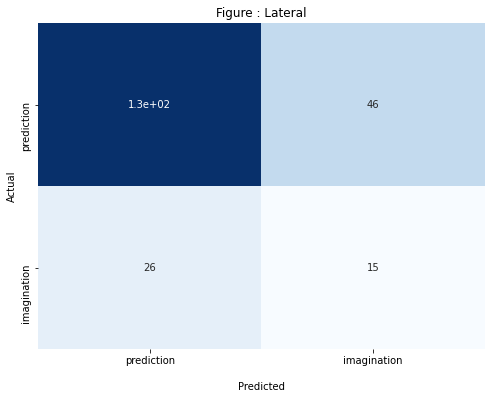

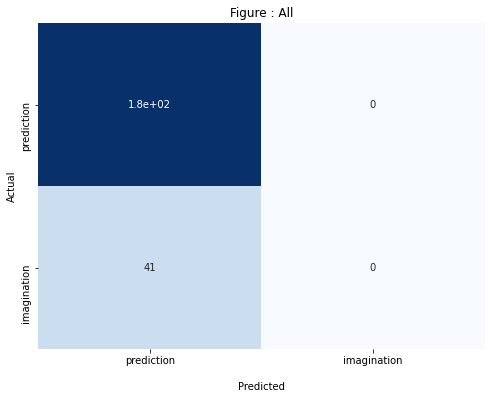

In [26]:
# CLASSIFY INTENTIONS
lateral_electrodes = EEG(channels = ["T7", "FT7", "TP7", "FT8", "T8", "TP8"], verbose=False) 
lateral_electrodes.prepare(task = "classify_intentions", split = "leave_participant_out", verbose=False) 

all_electrodes = EEG(verbose=False) 
all_electrodes.prepare(task = "classify_intentions", split = "leave_participant_out", verbose=False) 

lateral_electrodes_y_pred_valid = random_forrest_classifier(X_train = lateral_electrodes.X_train, 
                                   y_train = lateral_electrodes.y_train, 
                                   X_valid = lateral_electrodes.X_valid)

all_electrodes_y_pred_valid = random_forrest_classifier(X_train = all_electrodes.X_train, 
                                   y_train = all_electrodes.y_train, 
                                   X_valid = all_electrodes.X_valid)

rf_accuracy_lat = accuracy(lateral_electrodes_y_pred_valid, lateral_electrodes.y_valid)
rf_accuracy_all = accuracy(all_electrodes_y_pred_valid, all_electrodes.y_valid)


print("Lateral electrodes : ", rf_accuracy_lat)
fig1 = get_confusion_matrix_plot(y_true = lateral_electrodes.y_valid, 
                                 y_pred = lateral_electrodes_y_pred_valid, 
                                 title = "Figure : Lateral",
                                 task = "classify_intentions", 
                                 axis_labels = ['\nPredicted', 'Actual']
                                )
rf_accuracy_lat = accuracy(lateral_electrodes_y_pred_valid, lateral_electrodes.y_valid)
rf_accuracy_all = accuracy(all_electrodes_y_pred_valid, all_electrodes.y_valid)

print("All electrodes : ", rf_accuracy_all)
fig2 = get_confusion_matrix_plot(y_true = all_electrodes.y_valid, 
                                 y_pred = all_electrodes_y_pred_valid, 
                                 title = "Figure : All", 
                                 task = "classify_intentions", 
                                 axis_labels = ['\nPredicted', 'Actual']
                                )

Lateral electrodes :  tensor(0.0950)
All electrodes :  tensor(0.0860)


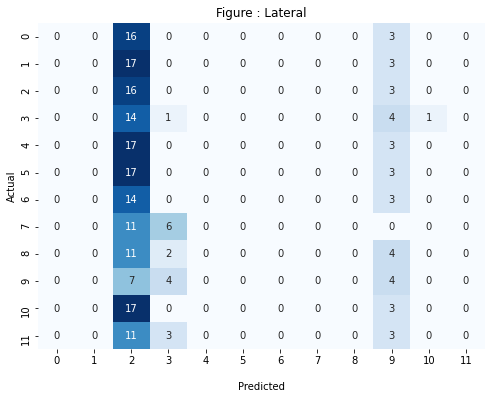

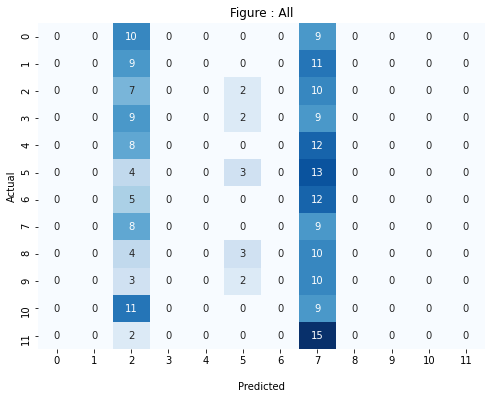

In [28]:
# CLASSIFY SONGS
lateral_electrodes = EEG(channels = ["T7", "FT7", "TP7", "FT8", "T8", "TP8"], verbose=False) 
lateral_electrodes.prepare(task = "classify_songs", split = "leave_participant_out", verbose=False) 

all_electrodes = EEG(verbose=False) 
all_electrodes.prepare(task = "classify_songs", split = "leave_participant_out", verbose=False) 

lateral_electrodes_y_pred_valid = random_forrest_classifier(X_train = lateral_electrodes.X_train, 
                                   y_train = lateral_electrodes.y_train, 
                                   X_valid = lateral_electrodes.X_valid)

all_electrodes_y_pred_valid = random_forrest_classifier(X_train = all_electrodes.X_train, 
                                   y_train = all_electrodes.y_train, 
                                   X_valid = all_electrodes.X_valid)

rf_accuracy_lat = accuracy(lateral_electrodes_y_pred_valid, lateral_electrodes.y_valid)
rf_accuracy_all = accuracy(all_electrodes_y_pred_valid, all_electrodes.y_valid)


print("Lateral electrodes : ", rf_accuracy_lat)
fig1 = get_confusion_matrix_plot(y_true = lateral_electrodes.y_valid, 
                                 y_pred = lateral_electrodes_y_pred_valid, 
                                 title = "Figure : Lateral",
                                 axis_labels = ['\nPredicted', 'Actual'],
                                 task = "classify_songs")
rf_accuracy_lat = accuracy(lateral_electrodes_y_pred_valid, lateral_electrodes.y_valid)
rf_accuracy_all = accuracy(all_electrodes_y_pred_valid, all_electrodes.y_valid)

print("All electrodes : ", rf_accuracy_all)
fig2 = get_confusion_matrix_plot(y_true = all_electrodes.y_valid, 
                                 y_pred = all_electrodes_y_pred_valid, 
                                 title = "Figure : All",
                                 axis_labels = ['\nPredicted', 'Actual'],
                                 task = "classify_songs")

Plotting Functions

Labels (Y)
- song names 

Features (X)
- 6 channels 
- 64 channels

Models
- Linear Regression
- Logistic Regression
- Naive Bayes Classifier
- Random Forrest Classifier
